# Fit model to GRAVITY and MATISSE data

This program opens the model, calculates the visibilities of the model, opens the data, calculates A and theta 
Rosseland and fits the model to the data.

Note: we are assuming here you run Turbospectrum and have obtained the spectra and intensities

In [1]:
#solve the integral with the sample using Simpson's method
from scipy import integrate
#get the Bessel 0th function with scipy.special
from scipy import special
#special.jv(0, x) x is the [] in the J0 expression
#import the other usual stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from astropy.io import fits as pyfits
from astropy.utils.data import get_pkg_data_filename
%matplotlib inline

In [2]:
#function to compute visibilities of the model
def visibility(wavelength, intensity, mus, ratio, theta, baseline):
    bessel_array=[]
    for item in wavelength:
        x_bessel=np.pi*float(ratio)*float(theta)*0.001*(float(baseline)/(np.array(item)*1e-6)*(1/206264.81))*(1-np.array(mus)**2)**0.5
        bessel_array.append(x_bessel)
#t_bessel_array=np.transpose(bessel_array)
    bessel=special.jv(0,bessel_array)
    integrant=(intensity*bessel*mus)
    wvisibility=integrate.simps(integrant, mus)/integrate.simps(intensity*mus,mus)
    return wvisibility

In [3]:
#function to bin the wavelength and flux of the model
def bin_w_flux(resolution, lmin, lmax, wavelength, flux):
    delta_lambda=3.4/resolution #K-band is in 2.0 mum
#delta_lambda
    bins2=np.arange(lmin, lmax+delta_lambda, delta_lambda)

    bin_w=[]
    bin_flux=[]
    for i in range(len(bins2)-1):
        cond_bin=(wavelength*0.0001<=bins2[i+1])&(wavelength*0.0001>=bins2[i])
        wmean=(bins2[i+1]+bins2[i])/2.
        bin_w.append(wmean)
        fmean4=np.mean(flux[cond_bin])
        bin_flux.append(fmean4)
    return bin_w, bin_flux

In [4]:
#function to obtain the binned intensities with respect of mu to integrate later and get the visibilites
def t_bin_intensity_mu(resolution, lmin, lmax, wavelength, mus, intensities):
    delta_lambda=3.4/resolution #K-band is in 2.0 mum
#delta_lambda
    bins2=np.arange(lmin, lmax+delta_lambda, delta_lambda)
    c, h = len(bins2)-1, len(mus) #do it for the intensities
    bin_intensity_mu=[[0 for x in range(c)] for y in range(h)] 

    for k in range(len(bins2)-1):
   #print(k)
        cond_bin=(wavelength*0.0001<=bins2[k+1])&(wavelength*0.0001>=bins2[k])

        for j in range(len(mus)):#len(all_intensities)
        #print(j)
            fmean2r=np.mean(intensities[j][cond_bin])
            bin_intensity_mu[j][k]=fmean2r

    t_bin_intensity_mu=np.transpose(bin_intensity_mu)
    t_bin_intensity_muu=np.transpose(bin_intensity_mu[1:])
    return t_bin_intensity_muu

In [5]:
#This is taken from Kateryna Kravchenko's files, to open GRAVITY data
def read_FITS(input_file):

# add MJD    
   
# Open FITS file
    ff=pyfits.open('%s'%(input_file))

    OB = ff[2].data[0][1] # target name
    print(OB)
    
    wave_SC_P1 = [] # wavelength array for science spectrum and polarization 1
    bandwidth_SC_P1 = []
    for i in range(len(ff[3].data)):
        wave_SC_P1.append(ff[3].data[i][0]*1.e10)
        bandwidth_SC_P1.append(ff[3].data[i][1]*1.e10)
#    print wave_SC_P1,bandwidth_SC_P1  
    
    wave_SC_P2 = [] # wavelength array for science spectrum and polarization 2
    bandwidth_SC_P2 = []
    for i in range(len(ff[4].data)):
        wave_SC_P2.append(ff[4].data[i][0]*1.e10)
        bandwidth_SC_P2.append(ff[4].data[i][1]*1.e10)
#    print wave_SC_P2,bandwidth_SC_P2      
    
    wave_FT_P1 = [] # wavelength array for fringe tracking spectrum and polarization 1
    bandwidth_FT_P1 = []
    for i in range(len(ff[5].data)):
        wave_FT_P1.append(ff[5].data[i][0]*1.e10)
        bandwidth_FT_P1.append(ff[5].data[i][1]*1.e10)
#    print wave_FT_P1,bandwidth_FT_P1  
    
    wave_FT_P2 = [] # wavelength array for fringe tracking spectrum and polarization 2
    bandwidth_FT_P2 = []
    for i in range(len(ff[6].data)):
        wave_FT_P2.append(ff[6].data[i][0]*1.e10)
        bandwidth_FT_P2.append(ff[6].data[i][1]*1.e10)
#    print wave_FT_P2,bandwidth_FT_P2  
    
# squared visibility for the FT and SC -> for P1 and P2 at 6 baselines    
# each of variables is a list with 6-baseline datasets: each dataset is an array with 
# length of wave array
    
    vis2_FT_P1 = []
    vis2err_FT_P1 = []
    vis2_FT_P2 = []
    vis2err_FT_P2 = []    
    
    vis2_SC_P1 = []
    vis2err_SC_P1 = []
    vis2_SC_P2 = []
    vis2err_SC_P2 = []      
        
    ucoord = []
    vcoord = []
    
    flag_vis2_P1=[]
    flag_vis2_P2=[]

    for i in range(len(ff[8].data)):
        vis2_FT_P1.append(ff[8].data[i][4]) 
        vis2err_FT_P1.append(ff[8].data[i][5]) 
        vis2_FT_P2.append(ff[12].data[i][4]) 
        vis2err_FT_P2.append(ff[12].data[i][5])  

        vis2_SC_P1.append(ff[16].data[i][4]) 
        vis2err_SC_P1.append(ff[16].data[i][5]) 
        vis2_SC_P2.append(ff[20].data[i][4]) 
        vis2err_SC_P2.append(ff[20].data[i][5])  
        
        ucoord.append(ff[8].data[i][6])
        vcoord.append(ff[8].data[i][7])
        print(ff[8].data[i][6],ff[8].data[i][7])
        print(ff[12].data[i][6],ff[12].data[i][7])        


        
        flag_vis2_P1.append(ff[16].data[i][9])
        flag_vis2_P2.append(ff[20].data[i][9])

# flux for the FT and SC -> for P1 and P2 at 4 telescopes    
# each of variables is a list with 4-telescope datasets: each dataset is an array with 
# length of wave array

    flux_FT_P1 = []
    fluxerr_FT_P1 = []
    flux_FT_P2 = []
    fluxerr_FT_P2 = []  

    flux_SC_P1 = []
    fluxerr_SC_P1 = []
    flux_SC_P2 = []
    fluxerr_SC_P2 = []      
    
    for i in range(len(ff[10].data)):
        flux_FT_P1.append(ff[10].data[i][4])
        fluxerr_FT_P1.append(ff[10].data[i][5])
        flux_FT_P2.append(ff[14].data[i][4])
        fluxerr_FT_P2.append(ff[14].data[i][5])    

        flux_SC_P1.append(ff[18].data[i][4])
        fluxerr_SC_P1.append(ff[18].data[i][5])
        flux_SC_P2.append(ff[22].data[i][4])
        fluxerr_SC_P2.append(ff[22].data[i][5])  

# closure phase for the FT and SC -> for P1 and P2 at 4 telescopes    
# each of variables is a list with 4-telescope datasets: each dataset is an array with 
# length of wave array

    T3_FT_P1 = []
    T3err_FT_P1 = []
    T3_FT_P2 = []
    T3err_FT_P2 = []  

    T3_SC_P1 = []
    T3err_SC_P1 = []
    T3_SC_P2 = []
    T3err_SC_P2 = []      
    
    for i in range(len(ff[9].data)):
        T3_FT_P1.append(ff[9].data[i][6])
        T3err_FT_P1.append(ff[9].data[i][7])
        T3_FT_P2.append(ff[13].data[i][6])
        T3err_FT_P2.append(ff[13].data[i][7])    

        T3_SC_P1.append(ff[17].data[i][6])
        T3err_SC_P1.append(ff[17].data[i][7])
        T3_SC_P2.append(ff[21].data[i][6])
        T3err_SC_P2.append(ff[21].data[i][7])  

    
    return OB,wave_SC_P1,wave_SC_P2,wave_FT_P1,wave_FT_P2,vis2_FT_P1,vis2err_FT_P1,vis2_FT_P2,vis2err_FT_P2,vis2_SC_P1,vis2err_SC_P1,vis2_SC_P2,vis2err_SC_P2,ucoord,vcoord,flux_FT_P1,fluxerr_FT_P1,flux_FT_P2,fluxerr_FT_P2,flux_SC_P1,fluxerr_SC_P1,flux_SC_P2,fluxerr_SC_P2,T3_FT_P1,T3err_FT_P1,T3_FT_P2,T3err_FT_P2,T3_SC_P1,T3err_SC_P1,T3_SC_P2,T3err_SC_P2,flag_vis2_P1,flag_vis2_P2 

In [6]:
#read the model
#radiative mdot -6.5
marcs4=pd.read_table("Turbospectrum2019/COM-v19.1/syntspec/T3600.0_md-6.50_25_v2023_tau0.05_v25_t5_RAD-lum_v2-4.4-15M-beta-1.10-gamma0.45.txt_18000-50000_xit2.0_mu1.0_164values_ben_ALL_v2_IR-V460-Car.intensity", sep="\s+", header=None, engine="python")
marcs4

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
0,18000.0,0.57640,266627.00,92146.50,0.557570,90472.00,0.558357,88590.80,0.559725,86424.30,...,0.001002,35182.8000,0.000988,35160.6000,0.000974,35138.1000,0.000962,35119.5000,0.000951,35100.6000
1,18000.1,0.70585,326498.00,116530.00,0.705129,113857.00,0.702695,110838.00,0.700299,107345.00,...,0.000602,21117.5000,0.000593,21103.8000,0.000584,21089.9000,0.000577,21078.5000,0.000570,21066.8000
2,18000.2,0.88925,411325.00,148590.00,0.899139,145232.00,0.896349,141359.00,0.893150,136766.00,...,0.000115,4032.1800,0.000113,4029.2900,0.000112,4026.3600,0.000110,4023.9400,0.000109,4021.4900
3,18000.3,0.91200,421842.00,152676.00,0.923881,149219.00,0.920971,145220.00,0.917564,140464.00,...,0.000009,325.5900,0.000009,325.2660,0.000009,324.9380,0.000009,324.6660,0.000009,324.3910
4,18000.4,0.92059,425808.00,154012.00,0.931987,150560.00,0.929272,146564.00,0.926078,141806.00,...,0.000002,84.5825,0.000002,84.4615,0.000002,84.3389,0.000002,84.2377,0.000002,84.1351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319996,49999.6,0.55853,6184.24,1595.34,0.430909,1592.35,0.434975,1589.12,0.439859,1585.63,...,0.000501,339196.0000,0.000494,338700.0000,0.000487,338197.0000,0.000481,337782.0000,0.000476,337361.0000
319997,49999.7,0.54434,6027.15,1668.13,0.450573,1662.31,0.454089,1655.76,0.458306,1648.27,...,0.000139,93881.2000,0.000137,93741.1000,0.000135,93599.1000,0.000133,93482.0000,0.000132,93363.3000
319998,49999.8,0.55976,6197.81,1789.08,0.483246,1781.16,0.486561,1772.09,0.490510,1761.43,...,0.000037,24814.6000,0.000036,24776.6000,0.000036,24738.0000,0.000035,24706.2000,0.000035,24674.0000
319999,49999.9,0.59431,6580.33,1951.39,0.527091,1941.89,0.530470,1930.94,0.534483,1917.96,...,0.000015,9954.0800,0.000015,9938.2100,0.000014,9922.1200,0.000014,9908.8500,0.000014,9895.4000


In [7]:
#simple marcs
marcs4m=pd.read_table("Turbospectrum2019/COM-v19.1/syntspec/s3600_g-0.5_m15._t05_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod_18000-50000_xit2.0_mu1.0_164values_ben_ALL_v2_IR-AH-Sco.intensity", sep="\s+", header=None, engine="python")
marcs4m

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
0,18000.0,0.57693,267088.00,92197.90,0.555941,92173.40,0.555957,92148.90,0.555973,92124.40,...,2.66967,1.69931,2.55814,1.69681,2.45032,1.69418,2.36507,1.69194,2.28179,1.68959
1,18000.1,0.70532,326518.00,116482.00,0.702386,116443.00,0.702356,116404.00,0.702325,116364.00,...,2.41524,1.53739,2.31508,1.53562,2.21826,1.53376,2.14170,1.53218,2.06691,1.53052
2,18000.2,0.88839,411261.00,148797.00,0.897263,148747.00,0.897225,148697.00,0.897187,148647.00,...,1.97568,1.25762,1.89389,1.25627,1.81482,1.25484,1.75230,1.25363,1.69123,1.25236
3,18000.3,0.91131,421864.00,152989.00,0.922559,152937.00,0.922518,152886.00,0.922477,152834.00,...,1.83203,1.16620,1.75608,1.16488,1.68266,1.16348,1.62460,1.16229,1.56790,1.16105
4,18000.4,0.91996,425860.00,154354.00,0.930807,154302.00,0.930769,154251.00,0.930731,154199.00,...,1.87092,1.19099,1.79295,1.18936,1.71757,1.18765,1.65796,1.18619,1.59974,1.18466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319996,49999.6,0.50790,5632.52,1630.96,0.440309,1630.91,0.440367,1630.87,0.440426,1630.82,...,1592.57000,31691.50000,1592.57000,33177.10000,1592.57000,34751.80000,1592.57000,36107.00000,1592.56000,37536.80000
319997,49999.7,0.52446,5816.16,1699.60,0.458843,1699.52,0.458896,1699.44,0.458949,1699.36,...,1585.92000,31559.50000,1585.62000,33032.50000,1585.31000,34593.70000,1585.06000,35937.20000,1584.81000,37354.40000
319998,49999.8,0.55501,6154.86,1812.22,0.489251,1812.11,0.489302,1812.01,0.489352,1811.90,...,1584.28000,31527.00000,1582.72000,32972.30000,1581.16000,34503.30000,1579.89000,35820.00000,1578.62000,37208.50000
319999,49999.9,0.59759,6627.09,1964.48,0.530362,1964.36,0.530414,1964.23,0.530465,1964.10,...,897.90600,17868.30000,884.25000,18421.40000,870.69700,19000.10000,859.73900,19492.60000,848.83500,20007.40000


In [8]:
#radiative mdot -6.0
marcs4j=pd.read_table("Turbospectrum2019/COM-v19.1/syntspec/T3600.0_md-6.00_25_v2023_tau0.05_v25_t5_RAD-lum_v2-4.4-15M-beta-1.10-gamma0.45.txt_18000-50000_xit2.0_mu1.0_164values_ben_ALL_v2_IR-V460-Car.intensity", sep="\s+", header=None, engine="python")
marcs4j

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
0,18000.0,0.57604,266452.00,92005.20,0.556725,90332.60,0.557507,88453.70,0.558870,86290.00,...,0.003180,35303.0000,0.003135,35281.0000,0.003090,35258.6000,0.003053,35240.1000,0.003016,35221.3000
1,18000.1,0.70549,326324.00,116416.00,0.704446,113745.00,0.702014,110728.00,0.699616,107237.00,...,0.001909,21189.8000,0.001882,21176.2000,0.001854,21162.3000,0.001832,21150.9000,0.001810,21139.3000
2,18000.2,0.88912,411255.00,148553.00,0.898929,145195.00,0.896137,141322.00,0.892940,136730.00,...,0.000365,4046.0100,0.000359,4043.1400,0.000354,4040.2200,0.000350,4037.8100,0.000346,4035.3600
3,18000.3,0.91197,421819.00,152666.00,0.923835,149208.00,0.920925,145209.00,0.917515,140454.00,...,0.000029,326.7080,0.000029,326.3840,0.000029,326.0560,0.000028,325.7850,0.000028,325.5110
4,18000.4,0.92057,425789.00,154004.00,0.931952,150552.00,0.929238,146556.00,0.926043,141798.00,...,0.000008,84.8703,0.000008,84.7494,0.000007,84.6268,0.000007,84.5257,0.000007,84.4231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319996,49999.6,0.62329,6901.11,1578.47,0.426365,1575.10,0.430276,1571.45,0.434981,1567.47,...,0.001586,339488.0000,0.001563,338990.0000,0.001541,338485.0000,0.001523,338069.0000,0.001505,337647.0000
319997,49999.7,0.56777,6286.39,1660.78,0.448602,1654.82,0.452057,1648.12,0.456207,1640.47,...,0.000439,93966.8000,0.000433,93826.3000,0.000427,93683.8000,0.000422,93566.3000,0.000417,93447.2000
319998,49999.8,0.56672,6274.64,1785.98,0.482424,1777.99,0.485709,1768.84,0.489626,1758.09,...,0.000116,24846.2000,0.000114,24808.1000,0.000113,24769.4000,0.000111,24737.5000,0.000110,24705.2000
319999,49999.9,0.59615,6600.47,1950.19,0.526784,1940.66,0.530150,1929.67,0.534148,1916.65,...,0.000047,9980.5900,0.000046,9964.6700,0.000045,9948.5300,0.000045,9935.2100,0.000044,9921.7200


In [9]:
#get the outer radius of the models
radius4=pd.read_table("T3600.0_md-6.50_25_v2023_tau0.05_v25_t5_RAD-lum_v2-4.4-15M-beta-1.10-gamma0.45.txt", skiprows=1, header=None, sep="\s+")
outer_rad4=radius4[2][0]

radius4j=pd.read_table("T3600.0_md-6.00_25_v2023_tau0.05_v25_t5_RAD-lum_v2-4.4-15M-beta-1.10-gamma0.45.txt", skiprows=1, header=None, sep="\s+")
outer_rad4j=radius4j[2][0]

outer_rad4m=4.4734E+13 #check in the MARCS file


#get the new R at tau_ross=2/3, it is not the same as of the MARCS models
models2=["/Turbospectrum2019/COM-v19.1/contopac/T3600.0_md-6.50_25_v2023_tau0.05_v25_t5_RAD-lum_v2-4.4-15M-beta-1.10-gamma0.45.txtopac.mod",
"/Turbospectrum2019/COM-v19.1/contopac/T3600.0_md-6.00_25_v2023_tau0.05_v25_t5_RAD-lum_v2-4.4-15M-beta-1.10-gamma0.45.txtopac.mod"
]

tol=0.1
ross=2/3
radius=[]
for item in models2:
    data_v2=pd.read_table("%s"%item, skiprows=1,sep="\s+", header=None,engine="python")
#log10 tau, T, log10 pe, log 10 pg, xi, radius.
    tauross2=data_v2[0]
    rad_v1=data_v2[5]
    cond_cont=(np.array(tauross2)<(ross+tol))&(np.array(tauross2)>(ross-tol))
    rad=np.mean(np.array(rad_v1[cond_cont]))
    radius.append(rad)

radius1=2.748E+11+outer_rad4m
ratio_rad4=outer_rad4/radius[0]
ratio_rad4j=outer_rad4j/radius[1]
ratio_rad4m=radius1/outer_rad4m

#how extended is the model 
print(ratio_rad4)
print(ratio_rad4j)
print(ratio_rad4m)

8.567733022376366
8.567733022376366
1.0061429784951044


In [10]:
#these are the initial mu values in turbospectrum, we have included more
mus_old=[1.0,0.96114,0.92229,0.88343,
             0.84458,
             0.80572,0.76687,0.72801,0.68916,0.65030,
             0.61145,0.57259,0.53374,0.49488,0.45603,
             0.41717,0.41664,0.41617,0.41575,0.41535,
             0.41493,0.41429,0.41207,0.40918,0.40402,
             0.39953,0.39593,0.39260,0.38931,0.38595,
             0.38240,0.37871,0.37496,0.37116,0.36729,
             0.36338,0.35942,0.35540,0.35129,0.34709,
             0.34277,0.33831,0.33370,0.32890,0.32390,
             0.31865,0.31314,0.30733,0.30120,0.29471,
             0.28786,0.28065,0.27307,0.26515,0.25688,
             0.24827,0.23932,0.23003,0.22038,0.21034,
             0.19988,0.18898,0.17758,0.16566,0.15321,
             0.14022,0.12676,0.11299,0.099143,0.085574,
             0.072675,0.060819,0.050271,
             0.041149,0.033440,
             0.027036,0.021783,0.017509]
#the included points
mus_wind=[0.999,0.998,0.997,0.996,0.995,0.994,0.993,0.992,0.991]
#add intermediate points:
mus_all=[]
mus_all.append(mus_old[0])

for item in mus_wind:
    mus_all.append(item)
    
mus_all.append((mus_old[0]+mus_old[1])/2)

for i in range(1,len(mus_old)-1):
    mus_all.append(mus_old[i])
    n_mus=(mus_old[i]+mus_old[i+1])/2.
    mus_all.append(n_mus)
#mus_all_new=interpfunc(rang)
#ax.plot(mus_all_new, rang,"x")
mus_all.append(mus_old[-1])
len(mus_all)
mus_allu=mus_all[1:]

In [11]:
#get intensities of the model
all_intensities_rad4=[]
w=marcs4[0]

flux4=marcs4[2]
items=np.arange(3,331,2)
items
for item in items:
    all_intensities_rad4.append(marcs4[item])

In [12]:
all_intensities_rad4j=[]
wj=marcs4j[0]
flux4j=marcs4j[2]
items=np.arange(3,331,2)
items
for item in items:
    all_intensities_rad4j.append(marcs4j[item])

In [13]:
all_intensities_rad4m=[]
wm=marcs4m[0]
flux4m=marcs4m[2]
items=np.arange(3,331,2)
items
for item in items:
    all_intensities_rad4m.append(marcs4m[item])

Fluxes and intensities of MATISSE:

In [14]:
#minimum and max lambda of model

lmin=1.8
#lmax=4.9995
lmax=5.0

#resolution
r2=506

#bin model to matisse resolution
bin_wm, bin_flux4m = bin_w_flux(r2, lmin, lmax, w, flux4)
bin_wm2, bin_flux4mj = bin_w_flux(r2, lmin, lmax, w, flux4j)
bin_wm3, bin_flux4mm = bin_w_flux(r2, lmin, lmax, w, flux4m)

In [15]:
#get binned intensities of model
t_bin_intensity_muu4m=t_bin_intensity_mu(r2, lmin, lmax, w, mus_all, all_intensities_rad4)

In [16]:
t_bin_intensity_muu4mj=t_bin_intensity_mu(r2, lmin, lmax, w, mus_all, all_intensities_rad4j)

In [17]:
t_bin_intensity_muu4mm=t_bin_intensity_mu(r2, lmin, lmax, w, mus_all, all_intensities_rad4m)

In [18]:
#observations: open MATISSE data
image_file = get_pkg_data_filename('/data/SCI_V-V460-Car_TARGET_CAL_INT_2022-12-27T05-01-22.1847_4.fits')

image_data = pyfits.getdata(image_file, ext=0)
image_wavelength=pyfits.getdata(image_file, ext=3)
image_vis2=pyfits.getdata(image_file, ext=4)
image_array=pyfits.getdata(image_file, ext=2)
image_target=pyfits.getdata(image_file, ext=1)

In [19]:
#check the baseline values of MATISSE
baselinesm=[]
for i in range(0,6):
    b=np.sqrt(image_vis2[i][6]**2+image_vis2[i][7]**2)
    print(b)
    baselinesm.append(b)
    
#Get the wavelength and visibilities of the MATISSE data  
w_data=[]
for i in range(len(image_wavelength[:])):
    w_data.append(image_wavelength[i][0])
vis2=[[0 for x in range(len(image_vis2[0][4]))] for y in range(6)]
for i in range(6):
    for j in range(len(image_vis2[0][4])):
        #print(j)
        vis2[i][j]=image_vis2[i][4][j]



97.06104906830176
67.17544203218756
36.582548320818
60.625264556050574
95.88574490971564
44.80214246602267


In [20]:
#get error of data
vis2err=[[0 for x in range(len(image_vis2[0][5]))] for y in range(6)]
for i in range(6):
    for j in range(len(image_vis2[0][5])):
        #print(j)
        vis2err[i][j]=image_vis2[i][5][j]

In [21]:
#take out the noise at ~4.4 mum of the data
vis2_new=[[0 for x in range(len(vis2[0]))] for y in range(6)]
for j in range(len(vis2)):
    for i in range(len(np.array(w_data))):
        if np.array(w_data)[i]>(4.15*1e-6) and np.array(w_data)[i]<(4.5*1e-6):
            vis2_new[j][i]= np.nan
        else:
            vis2_new[j][i]=vis2[j][i]

In [22]:
#take out the noise at ~4.4 mum of the data
vis2err_new=[[0 for x in range(len(vis2err[0]))] for y in range(6)]
for j in range(len(vis2err)):
    for i in range(len(np.array(w_data))):
        if np.array(w_data)[i]>(4.15*1e-6) and np.array(w_data)[i]<(4.5*1e-6):
            vis2err_new[j][i]= np.nan
        else:
            vis2err_new[j][i]=vis2err[j][i]

In [23]:
#open MATISSE calibrated flux
flux_sco=pd.read_table("/data/mean-flux-V460-Car.txt", sep=",")
w_scom=flux_sco["w"]
f_scom=flux_sco["flux"]

In [24]:
#take out the noise at ~4.4 mum of the data
f_scom_new=[]
#for j in range(len(f_sco)):
for i in range(len(np.array(w_scom))):
    if np.array(w_scom)[i]>(4.15) and np.array(w_scom)[i]<(4.54):
        f_scom_new.append(np.nan)
    else:
        f_scom_new.append(f_scom[i])

Fluxes and intensities of GRAVITY

In [25]:
#minimum and max lambda of model

lmin=1.8
#lmax=4.9995
lmax=5.0

#GRAVITY resolution
r3=4000

#get binned wavelength and flux of model
bin_wmg, bin_flux4mg = bin_w_flux(r3, lmin, lmax, w, flux4)
bin_wm2g, bin_flux4mjg = bin_w_flux(r3, lmin, lmax, w, flux4j)
bin_wm3g, bin_flux4mmg = bin_w_flux(r3, lmin, lmax, w, flux4m)

In [26]:
#get intensity 
t_bin_intensity_muu4mg=t_bin_intensity_mu(r3, lmin, lmax, w, mus_all, all_intensities_rad4)

In [27]:
t_bin_intensity_muu4mjg=t_bin_intensity_mu(r3, lmin, lmax, w, mus_all, all_intensities_rad4j)

In [28]:
t_bin_intensity_muu4mmg=t_bin_intensity_mu(r3, lmin, lmax, w, mus_all, all_intensities_rad4m)

In [29]:
#observations
hdul = pyfits.open('/data/SCI_V-V460-Car_SINGLE_SCI_VIS_CALIBRATED.fits')  # open a FITS file

hdr = hdul[0].header

In [30]:

#read fits obervation of GRAVITY
OB,wave_SC_P1,wave_SC_P2,wave_FT_P1,wave_FT_P2,vis2_FT_P1,vis2err_FT_P1,vis2_FT_P2,vis2err_FT_P2,vis2_SC_P1,vis2err_SC_P1,vis2_SC_P2,vis2err_SC_P2,ucoord,vcoord,flux_FT_P1,fluxerr_FT_P1,flux_FT_P2,fluxerr_FT_P2,flux_SC_P1,fluxerr_SC_P1,flux_SC_P2,fluxerr_SC_P2,T3_FT_P1,T3err_FT_P1,T3_FT_P2,T3err_FT_P2,T3_SC_P1,T3err_SC_P1,T3_SC_P2,T3err_SC_P2,flag_vis2_P1,flag_vis2_P2 = read_FITS('/data/SCI_V-V460-Car_SINGLE_SCI_VIS_CALIBRATED.fits')

V_V460_Car
-37.208945246698704 -91.39151585076473
-37.208945246698704 -91.39151585076473
-25.45615731636096 -56.11826641103196
-25.45615731636096 -56.11826641103196
33.02292331922045 -26.132191435675452
33.02292331922045 -26.132191435675452
11.752787930337457 35.27324943973248
11.752787930337457 35.27324943973248
70.2318685659179 65.25932441508925
70.2318685659179 65.25932441508925
58.4790806355799 29.986074975355496
58.4790806355799 29.986074975355496
-38.06623438204165 -90.94331548533452
-38.06623438204165 -90.94331548533452
-25.99355099377137 -55.81202915216183
-25.99355099377137 -55.81202915216183
32.96158414796978 -26.523358505731967
32.96158414796978 -26.523358505731967
12.072683388270324 35.13128633317442
12.072683388270324 35.13128633317442
71.02781853001319 64.41995697960296
71.02781853001319 64.41995697960296
58.955135141741856 29.288670646430422
58.955135141741856 29.288670646430422
-39.858025424242086 -89.96077288519894
-39.858025424242086 -89.96077288519894
-27.11543379758

In [31]:
#get baselines of GRAVITY
baselinesg0=[]
for i in range(len(ucoord)):
    b=np.sqrt(ucoord[i]**2+vcoord[i]**2)
    #print(b)
    baselinesg0.append(b)
baselinesg0

[98.67580643639252,
 61.622039647311865,
 42.111814182933315,
 37.179700781112714,
 95.8712406583655,
 65.71885242767327,
 98.58866482255257,
 61.5682328100097,
 42.30785477860201,
 37.14777198725256,
 95.88994661791392,
 65.82958444207377,
 98.39513630673963,
 61.44877922866602,
 42.71498899313793,
 37.07666642841851,
 95.92227738573784,
 66.05844322061037,
 98.30046259080386,
 61.3903560244938,
 42.90147130852662,
 37.0417991819017,
 95.93382384662782,
 66.16259714164914]

In [32]:
#get wavelenght, vis2 and error of vis2 of GRAVITY observations
wave_SC_Pmean0=[]
vis2_SC_Pmean0=[]
vis2err_SC_Pmean0=[]

for i in range(len(wave_SC_P1)):
    wmean_Pi=(wave_SC_P1[i]+wave_SC_P2[i])/2.
    wave_SC_Pmean0.append(wmean_Pi)

for i in range(len(vis2_SC_P1)):
    vmean_P=[]
    vmean_errP=[]
    for j in range(len(vis2_SC_P1[i])):

        vmean_Pi=(vis2_SC_P1[i][j]+vis2_SC_P2[i][j])/2.
        vmean_P.append(vmean_Pi)
        
        vmean_errPi=(vis2err_SC_P1[i][j]+vis2err_SC_P2[i][j])/2.
        vmean_errP.append(vmean_errPi)
   
    vis2_SC_Pmean0.append(vmean_P)
    vis2err_SC_Pmean0.append(vmean_errP)

In [33]:
#indexes of the data for each baseline, just to arrange it from high to low values
indexes_b=[]
for i in range(0,6):
    idx=np.arange(i,len(baselinesg0),6)
    print(idx)
    indexes_b.append(idx)

[ 0  6 12 18]
[ 1  7 13 19]
[ 2  8 14 20]
[ 3  9 15 21]
[ 4 10 16 22]
[ 5 11 17 23]


In [34]:
#arrange data from high to low baseline values
baselinesg=[]
#wave_SC_Pmean=[]
vis2_SC_Pmean=[]
vis2err_SC_Pmean=[]

for item in indexes_b:
    #print(item)
    print(np.array(baselinesg0)[item].mean(axis=0))
    baselinesg.append(np.array(baselinesg0)[item].mean(axis=0))
    #print(np.array(baselinesg0)[item].mean(axis=1))
    #for i in range(0,2):
        #print(item[i])
    print(np.array(vis2_SC_Pmean0)[item].mean(axis=0))
    vis2_SC_Pmean.append(np.array(vis2_SC_Pmean0)[item].mean(axis=0))
    #wave_SC_Pmean.append(np.array(wave_SC_Pmean0)[item].mean(axis=0))
    vis2err_SC_Pmean.append(np.array(vis2err_SC_Pmean0)[item].mean(axis=0))
    #print(np.array(vis2_SC_Pmean0)[item]) 
wave_SC_Pmean=wave_SC_Pmean0

98.49001753912215
[0.02281763 0.02081065 0.02076634 ... 0.10435018 0.10454665 0.1091925 ]
61.50735192762034
[0.31469379 0.31509221 0.30835999 ... 0.44823609 0.4545399  0.45055745]
42.50903231579997
[0.55812627 0.58100138 0.56855697 ... 0.66487482 0.67005839 0.66701294]
37.111484594671374
[0.72345608 0.75071796 0.71636275 ... 0.73886756 0.74303992 0.73127165]
95.90432212716128
[0.03709782 0.02881105 0.02743702 ... 0.119514   0.12401669 0.12346167]
65.94236930800164
[0.25396958 0.26177688 0.25444147 ... 0.38892616 0.38697779 0.39313166]


In [35]:
#open GRAVITY calibrated flux
flux_scog=pd.read_table("/data/mean-flux-V460-Car-GRAVITY.txt", sep=",")
w_scog=flux_scog["w"]
f_scog=flux_scog["flux"]
flux_scog

,w,flux
0,19693.938348,1.107874e+06
1,19696.580430,1.159032e+06
2,19699.222513,1.126182e+06
3,19701.866868,1.108564e+06
4,19704.508951,1.111991e+06
...,...,...
1623,23983.365473,4.587349e+05
1624,23986.009829,3.526799e+05
1625,23988.651911,3.999095e+05
1626,23991.293993,2.466443e+05


(2.8, 5.0)

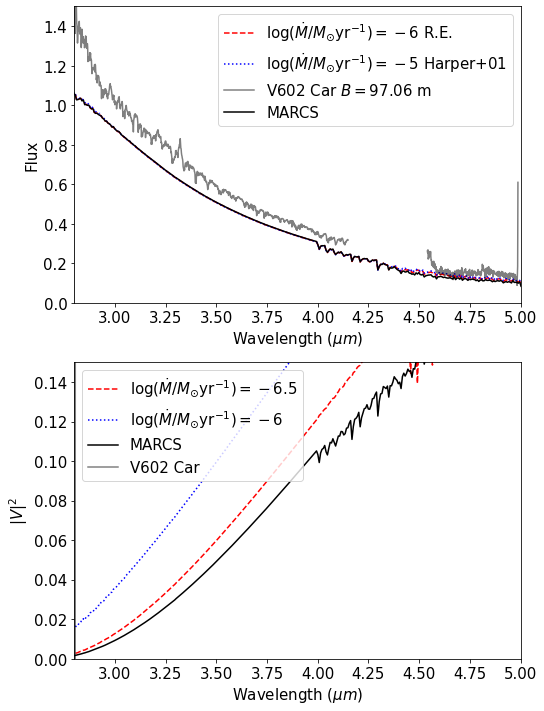

In [36]:
#this is just a trial to plot the data and the model, the theta_ross and A are made up
theta_ross4m=6.
theta_ross4mj=5.5
theta_ross4mm=7
#theta_ross=4.75
a=0.83

# Get visibilities, Plot to see if everything is alright?
w4visibility1m=visibility(bin_wm, t_bin_intensity_muu4m, mus_allu, ratio_rad4, theta_ross4m, baselinesm[0])
w4jvisibility1m=visibility(bin_wm2, t_bin_intensity_muu4mj, mus_allu, ratio_rad4j, theta_ross4mj, baselinesm[0])
w4mvisibility1m=visibility(bin_wm3, t_bin_intensity_muu4mm, mus_allu, ratio_rad4m, theta_ross4mm, baselinesm[0])

fig = plt.figure(figsize=(8,12))
ax =fig.add_subplot((212))
ax2=fig.add_subplot(211)

ax.plot(bin_wm, (a*w4visibility1m)**2, c="r", ls="--", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6.5$")
ax.plot(bin_wm2, (a*w4jvisibility1m)**2, c="b", ls=":", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6$")
ax.plot(bin_wm3, (a*w4mvisibility1m)**2, c="k", label=r"MARCS")
#cond_data=(np.array(w_data)>(4.15*1e-6))&(np.array(w_data)<(4.5*1e-6))
for i in range(0,1):#len(vis2)
    ax.plot(np.array(w_data)*1e+6, vis2_new[i], c="k", alpha=0.5, label="V602 Car")
    #ax.plot(np.array(w_data)[cond]*1e+6, np.array(vis2)[i][cond], color="white")
ax.set_ylim(0,0.15)
#ax.set_xlim(min(w1000rad),max(w1000rad))
ax.set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
ax.set_ylabel(r"$|V|^{2}$", fontsize=15)
ax.legend(loc=2,prop={'size':15})
ax.tick_params(labelsize=15)
ax.set_xlim(2.8, 5.0)
#fig.savefig("KW-Sgr-MATISSE-model-fit4.png")

ax2.plot(bin_wm, bin_flux4m/np.mean(np.array(bin_flux4m)), c="r", ls="--", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6$ R.E.")
ax2.plot(bin_wm2, bin_flux4mj/np.mean(np.array(bin_flux4mj)), c="b", ls=":",label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-5$ Harper+01")
ax2.plot(w_scom, np.array((f_scom_new))*0.5, c="k", alpha=0.5, label=r"V602 Car $B=%.2f$ m"%baselinesm[0])
ax2.plot(bin_wm3, bin_flux4mm/np.mean(np.array(bin_flux4mm)), c="black", label=r"MARCS")
ax2.set_ylim(0,1.5)
#ax.set_xlim(min(w1000rad),max(w1000rad))
ax2.set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
ax2.set_ylabel(r"Flux", fontsize=15)
ax2.legend(loc=1,prop={'size':15})
ax2.tick_params(labelsize=15)
ax2.set_xlim(2.8, 5.0)
#fig.savefig("AH-Sco-MATISSE-mdot4-RE-HARP2.png")

No handles with labels found to put in legend.


Text(0.5, 0, 'Wavelength $(\\mu m)$')

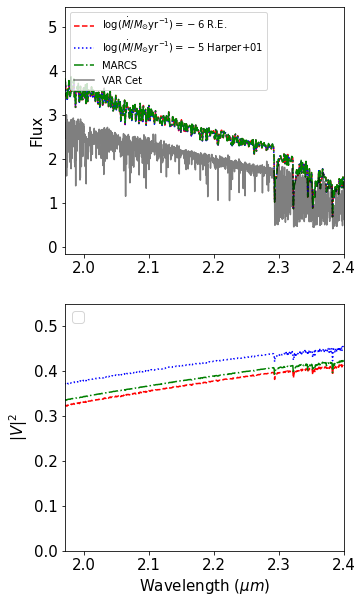

In [37]:
#same but with GRAVITY, this is a trial, the theta ross and A are not the correct ones!
theta_ross4m=5.5
theta_ross4mj=5
theta_ross4mm=6
#theta_ross=4.75
a=0.83
#Define an array for the baselinesg and the model
w4visibilitymg=[]
w4jvisibilitymg=[]
w4mvisibilitymg=[]

for i in range(len(baselinesg)):
    w4visibility1mg=visibility(bin_wmg, t_bin_intensity_muu4mg, mus_allu, ratio_rad4, theta_ross4m, baselinesg[i])
    w4visibilitymg.append(w4visibility1mg)
    
    w4jvisibility1mg=visibility(bin_wm2g, t_bin_intensity_muu4mjg, mus_allu, ratio_rad4j, theta_ross4mj, baselinesg[i])
    w4jvisibilitymg.append(w4jvisibility1mg)
    
    w4mvisibility1mg=visibility(bin_wm3g, t_bin_intensity_muu4mmg, mus_allu, ratio_rad4m, theta_ross4mm, baselinesg[i])
    w4mvisibilitymg.append(w4mvisibility1mg)
#fig, axs = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
#axs[0].plot(x, y)
#axs[1].plot(x, -y)

#so far we have seen baselines[0], let's plot all
#fig = plt.figure(figsize=(8,12))
fig, ax =plt.subplots(2, figsize=(5,10))
#ax[0]=fig.add_subplot(211)

ax[0].plot(bin_wmg, bin_flux4mg/np.mean(np.array(bin_flux4mg)), c="r", ls="--", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6$ R.E.")
ax[0].plot(bin_wm2g, bin_flux4mjg/np.mean(np.array(bin_flux4mjg)), c="b", ls=":",label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-5$ Harper+01")
ax[0].plot(bin_wm3g, bin_flux4mmg/np.mean(np.array(bin_flux4mmg)), c="g", ls="-.", label=r"MARCS")
ax[0].plot(np.array(w_scog)*1e-4, np.array((f_scog))*2.5e-6, c="k", alpha=0.5, label=r"VAR Cet")

#ax[0].set_ylim(0,1.5)
#ax.set_xlim(min(w1000rad),max(w1000rad))
#ax[0].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
ax[0].set_ylabel(r"Flux", fontsize=15)
ax[0].legend(loc=2,prop={'size':10})
ax[0].tick_params(labelsize=15)
ax[0].set_xlim(min(wave_SC_Pmean)*1e-4, max(wave_SC_Pmean)*1e-4)

#for i in range(4,5):
i=4
ax[1].plot(bin_wmg, (a*w4visibilitymg[i-1])**2, c="r", ls="--")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ R.E")
ax[1].plot(bin_wm2g, (a*w4jvisibilitymg[i-1])**2, c="b", ls=":")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ Harper+01")
ax[1].plot(bin_wm3g, (a*w4mvisibilitymg[i-1])**2, c="g", ls="-.")
               #,label=r"MARCS")
#cond_data=(np.array(w_data)>(4.15*1e-6))&(np.array(w_data)<(4.5*1e-6))
    #for i in range():#len(vis2)
ax[1].plot(np.array(wave_SC_Pmean)*1e-4, vis2_SC_Pmean[i-1], c="k", label="", alpha=0.3)
    #ax[i].plot(np.array(w_data)*1e+6, vis2_new[i-1], c="k", alpha=0.5, label=r"$B=%.2f$ m"%baselines[i-1])
    #ax.plot(np.array(w_data)[cond]*1e+6, np.array(vis2)[i][cond], color="white")
ax[1].set_ylim(0,0.55)
#ax.set_xlim(min(w1000rad),max(w1000rad))

ax[1].set_ylabel(r"$|V|^{2}$", fontsize=15)
ax[1].legend(loc=2,prop={'size':15})
ax[1].tick_params(labelsize=15)
ax[1].set_xlim(min(wave_SC_Pmean)*1e-4, max(wave_SC_Pmean)*1e-4)
ax[-1].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
#fig.savefig("KW-Sgr-GRAVITY-model-fit4-17-june.png")


#fig.savefig("AH-Sco-GRAVITY-mdot4-RE-H-M-all-baselines.png")

# Fit best Am, Ag and theta

The theta should be the same for both GRAVITY and MATISSE, the A can change.

Strategy 1:
Fit the best Agravity and theta. Then fix the theta and fit the best Amatisse

In [44]:
#define grid
theta_ross_arr=np.arange(2,4,0.05)
#a_arr_m=np.arange(0.80,1.,0.01)
a_arr_g=np.arange(0.70,1.,0.05)
#theta_ross_arr

In [45]:
b_arr2=np.arange(0,300,5)
b_arr1=[ *baselinesm, *baselinesg]
#idxs_order=sorted(range(len(b_arr1)), key=lambda k: b_arr1[k])
b_arr=[*baselinesm,*baselinesg,*b_arr2]
b_arr=sorted(b_arr)

indexes_chi2g=[]
for i in range(len(b_arr)):
    for item in baselinesg:
        if b_arr[i]==item:
            print(i)
            indexes_chi2g.append(i)
print("------------------------------")
indexes_chi2m=[]
for i in range(len(b_arr)):
    for item in baselinesm:
        if b_arr[i]==item:
            print(i)
            indexes_chi2m.append(i)

9
11
18
20
29
31
------------------------------
8
12
17
21
28
30


In [46]:
print(np.array(b_arr)[indexes_chi2g])
print("------")
print(baselinesg)

[37.11148459 42.50903232 61.50735193 65.94236931 95.90432213 98.49001754]
------
[98.49001753912215, 61.50735192762034, 42.50903231579997, 37.111484594671374, 95.90432212716128, 65.94236930800164]


Fit for GRAVITY

In [47]:
#RAD EQ model

bin_wmg=np.array(bin_wmg)
cond_w=(bin_wmg<=2.27)&(bin_wmg>=2.23)


c, h = len(a_arr_g), len(theta_ross_arr) #do it for the intensities
visibility_b_arr_ta=[[0 for x in range(c)] for y in range(h)] 
for j in range(len(a_arr_g)):
    for k in range(len(theta_ross_arr)):
#fix one lambda = 2 mum

        visibility_b_arr=[]
        for u in range(len(bin_wmg[cond_w])):
            bessel_b=[]
            for v in range(len(b_arr)):
                x_bessel=np.pi*float(ratio_rad4)*float(theta_ross_arr[k])*0.001*(float(b_arr[v])/(bin_wmg[cond_w][u]*1e-6)*(1/206264.81))*(1-np.array(mus_allu)**2)**0.5
    #bessel_w.append(x_bessel)
                bessel_b.append(x_bessel)
            bessel=special.jv(0,bessel_b)
            integrant=t_bin_intensity_muu4mg[cond_w][u]*bessel*mus_allu
            visibility_b_indiv=integrate.simps(integrant, mus_allu)/integrate.simps(t_bin_intensity_muu4mg[cond_w][u]*mus_allu,mus_allu)
    #print(visibility_b_indiv)
            visibility_b_arr.append(visibility_b_indiv)
#visibility_b_arr
#visibility_b_arr[59][0]
        visibility_b=[]
        for ji in range(len(b_arr)):
            vis_b=[]
            for ij in range(len(bin_wmg[cond_w])):
        #print(visibility_b_arr[i][j])
                vis_b.append(visibility_b_arr[ij][ji])
            visibility_b.append(np.mean(vis_b))
        visibility_b_arr_ta[k][j]=a_arr_g[j]*np.array(visibility_b)

In [48]:

cond_ahsco=(np.array(wave_SC_Pmean)*1e-4<=2.27)&(np.array(wave_SC_Pmean)*1e-4>=2.23)

v_ahsco_all=[]
err_v_ahsco_all=[]
for i in range(len(vis2_SC_Pmean)):
    v_ahsco=np.mean(np.array(vis2_SC_Pmean)[i][cond_ahsco])
    v_ahsco_all.append(v_ahsco)
    err_v_ahsco=np.mean(np.array(vis2err_SC_Pmean)[i][cond_ahsco])
    err_v_ahsco_all.append(err_v_ahsco)
#v2_c=np.mean(v2[cond_ahsco])
#errv2_c=np.mean(errv2[cond_ahsco])
#v3_c=np.mean(v3[cond_ahsco])
#errv3_c=np.mean(errv3[cond_ahsco])
#v_ahsco1=[v1_c,v2_c,v3_c]
#errv_ahsco1=[errv1_c, errv2_c, errv3_c]

#v_ahsco_all=#[*v_ahsco1,*v_ahsco2]
#v_ahsco_all=np.array(v_ahsco_all)[idxs_order]
#err_v_ahsco_all=[*errv_ahsco1,*errv_ahsco2]
#err_v_ahsco_all=np.array(err_v_ahsco_all)[idxs_order]
v_ahsco_all
baselinesg
np.array(b_arr)[indexes_chi2g]
idxs_order=sorted(range(len(baselinesg)), key=lambda k: baselinesg[k])

(0.0, 295.0)

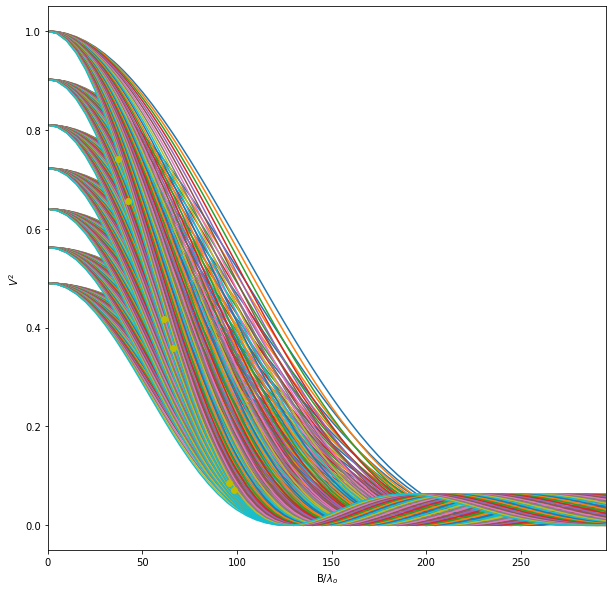

In [49]:
#all the different possible models, now find the best fitting one with a chi2 minimization
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot((111))
for k in range(len(a_arr_g)):
    for i in range(len(theta_ross_arr)):
        ax.plot(b_arr, (visibility_b_arr_ta[i][k])**2, label="R.E. theta=$%.2f$ A=$%.2f$"%(theta_ross_arr[i],a_arr_g[k]))
##ax.plot(b_arr, (0.81*np.array(visibility_b_phoenix))**2, c="k", ms=10, label="PHOENIX")
ax.errorbar(baselinesg, v_ahsco_all, yerr=err_v_ahsco_all, fmt="o", c="y", label="AH-Sco")
#ax.errorbar(b1, v_ahsco1, yerr=errv_ahsco1, fmt="o",c="g", label="AH-Sco K21")
#ax.errorbar(b2,v_ahsco2, yerr=errv_ahsco2, fmt="x", c="m",label="AH-Sco K23")
ax.set_xlabel(r"B/$\lambda_{o}$")
ax.set_ylabel(r"$V^{2}$")
ax.set_xlim(0,max(b_arr))
#ax.legend()

In [50]:
#Chi square minimization to find the best fitting theta Ross and A
c, h = len(a_arr_g), len(theta_ross_arr) #do it for the intensities
chi2_arr=[[0 for x in range(c)] for y in range(h)] 

for j in range(len(a_arr_g)):
    for i in range(len(theta_ross_arr)):
        chi2=np.sum(((np.array(visibility_b_arr_ta[i][j])[indexes_chi2g])**2-np.array(v_ahsco_all)[idxs_order])**2/(np.array(err_v_ahsco_all)[idxs_order])**2)
        print(np.abs(chi2))
        chi2_arr[i][j]=chi2

chisq=np.array(chi2_arr)

idxt, idxa= np.unravel_index(chisq.argmin(), chisq.shape)
print("Best fit: ")
print("Theta Ross: ",theta_ross_arr[idxt])
print("A: ", a_arr_g[idxa])
print("Min chi2_sigma: ",np.min(chisq))

idxt

82495.41513603722
77094.15229323381
71906.148577729
66939.64397821316
62201.764707078575
57698.52426689762
53434.83043904773
49414.498000053536
45640.26693812861
42113.82591169022
38835.84066345051
35805.987078221355
33022.988549910035
30484.657303450513
28187.93930066715
26128.962345375618
24303.086992411387
22704.95985775267
21328.568922465412
20167.30042179978
19213.996912362632
18461.01611479449
17900.290136694748
17523.384690539737
17321.55793388674
17285.81857408474
17406.98289684658
17675.73039717672
18082.65771208947
18618.330577073193
19273.333552130367
20038.317288219405
20904.04313080492
21861.424883754717
22901.56758376892
24015.803162660344
25195.722901902027
26433.206610700763
27720.44848523999
29049.97963246302
113728.55397572882
106018.22814680127
98583.92648573792
91437.05860226158
84587.56348190278
78043.91008186075
71813.10574646718
65900.7121875319
60310.86873119345
55046.3224923738
50108.46510075854
45497.375568605814
41211.868860770024
37249.54970126119
33606.8711

39

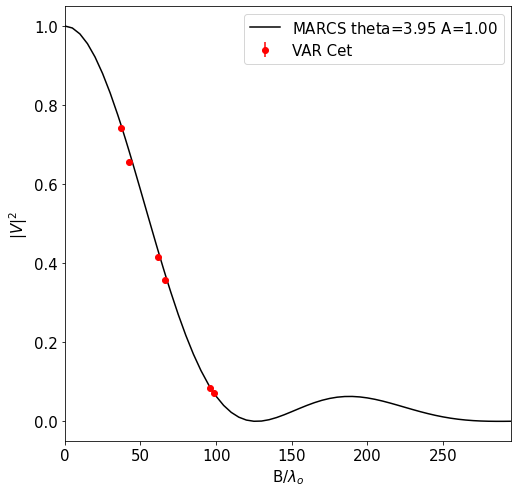

In [51]:
#Plot model with best found theta ross and A

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot((111))

ax.plot(b_arr, (visibility_b_arr_ta[idxt][idxa])**2,c="k",
        label="MARCS theta=$%.2f$ A=$%.2f$"%(theta_ross_arr[idxt],a_arr_g[idxa]))
##ax.plot(b_arr, (a_p*np.array(visibility_b_phoenix))**2, c="k", ms=10, label="PHOENIX")
ax.errorbar(baselinesg, v_ahsco_all, yerr=err_v_ahsco_all, fmt="o", c="r", label="VAR Cet")
#ax.errorbar(b1, v_ahsco1, yerr=errv_ahsco1, fmt="o",c="g", label="AH-Sco K21")
#ax.errorbar(b2,v_ahsco2, yerr=errv_ahsco2, fmt="x", c="m",label="AH-Sco K23")
ax.set_xlabel(r"B/$\lambda_{o}$", fontsize=15)
ax.set_ylabel(r"$|V|^{2}$", fontsize=15)
ax.set_xlim(0,max(b_arr))
ax.legend(loc=1, prop={'size':15})
ax.tick_params(labelsize=15)

#fig.savefig("Best_theta_ross_gravity-var-cet-6p5.png", bbox_inches='tight', dpi=300)
#fig.savefig("Best_theta_ross_MARCS_V_UY-sct.png")
#a_p

In [52]:
#define this new best-fit
theta_ross=theta_ross_arr[idxt]
a_g=a_arr_g[idxa]

find the best A_m fixing theta_ross

In [55]:

cond_ahsco=(np.array(w_data)*1e+6<=3.45)&(np.array(w_data)*1e+6>=3.25)

v_ahsco_allm=[]
err_v_ahsco_allm=[]
for i in range(len(vis2_new)):
    v_ahscom=np.mean(np.array(vis2_new)[i][cond_ahsco])
    v_ahsco_allm.append(v_ahscom)
    err_v_ahscom=np.mean(np.array(vis2err_new)[i][cond_ahsco])
    err_v_ahsco_allm.append(err_v_ahscom)
#v2_c=np.mean(v2[cond_ahsco])
#errv2_c=np.mean(errv2[cond_ahsco])
#v3_c=np.mean(v3[cond_ahsco])
#errv3_c=np.mean(errv3[cond_ahsco])
#v_ahsco1=[v1_c,v2_c,v3_c]
#errv_ahsco1=[errv1_c, errv2_c, errv3_c]

#v_ahsco_all=#[*v_ahsco1,*v_ahsco2]
#v_ahsco_all=np.array(v_ahsco_all)[idxs_order]
#err_v_ahsco_all=[*errv_ahsco1,*errv_ahsco2]
#err_v_ahsco_all=np.array(err_v_ahsco_all)[idxs_order]
v_ahsco_allm
baselinesm
np.array(b_arr)[indexes_chi2m]
idxs_orderm=sorted(range(len(baselinesm)), key=lambda k: baselinesm[k])

[97.06104906830176,
 67.17544203218756,
 36.582548320818,
 60.625264556050574,
 95.88574490971564,
 44.80214246602267]

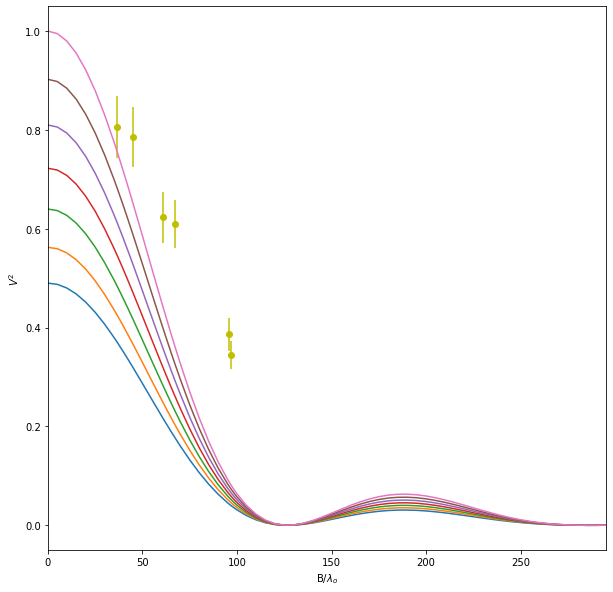

In [56]:
#same with MATISSE
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot((111))
for k in range(len(a_arr_g)):
    #for i in range(len(theta_ross_arr)):
        ax.plot(b_arr, (visibility_b_arr_ta[idxt][k])**2, label="R.E. theta=$%.2f$ A=$%.2f$"%(theta_ross,a_arr_g[k]))
##ax.plot(b_arr, (0.81*np.array(visibility_b_phoenix))**2, c="k", ms=10, label="PHOENIX")
ax.errorbar(baselinesm, v_ahsco_allm, yerr=err_v_ahsco_allm, fmt="o", c="y", label="AH-Sco")
#ax.errorbar(b1, v_ahsco1, yerr=errv_ahsco1, fmt="o",c="g", label="AH-Sco K21")
#ax.errorbar(b2,v_ahsco2, yerr=errv_ahsco2, fmt="x", c="m",label="AH-Sco K23")
ax.set_xlabel(r"B/$\lambda_{o}$")
ax.set_ylabel(r"$V^{2}$")
ax.set_xlim(0,max(b_arr))
#ax.legend()
baselinesm

In [57]:
#get best fitting Am with a Chi2 minimization
#c, h = len(a_arr_g), len(theta_ross_arr) #do it for the intensities
chi2_arrm=[]

for j in range(len(a_arr_g)):
   # for i in range(len(theta_ross_arr)):
    chi2=np.sum(((np.array(visibility_b_arr_ta[idxt][j])[indexes_chi2m])**2-np.array(v_ahsco_allm)[idxs_orderm])**2/(np.array(err_v_ahsco_allm)[idxs_orderm])**2)
    print(np.abs(chi2))
    chi2_arrm.append(chi2)

chisqm=np.array(chi2_arrm)

#idxt, idxa= np.unravel_index(chisq.argmin(), chisq.shape)
idxam=chisqm.argmin()
print("Best fit: ")
print("Theta Ross: ",theta_ross)
print("A: ", a_arr_g[idxam])
print("Min chi2_sigma: ",np.min(chisqm))

#idxt

467.1498095756151
417.63021882419616
369.4171320121438
323.45487876528216
280.74871320142375
242.36481393036985
209.43028405391033
Best fit: 
Theta Ross:  3.949999999999993
A:  1.0000000000000002
Min chi2_sigma:  209.43028405391033


In [58]:
#define this new value
a_m=a_arr_g[idxam]

Replot with new parameters

In [59]:
print(a_g, a_m, theta_ross)

1.0000000000000002 1.0000000000000002 3.949999999999993


1.0000000000000002
3.949999999999993


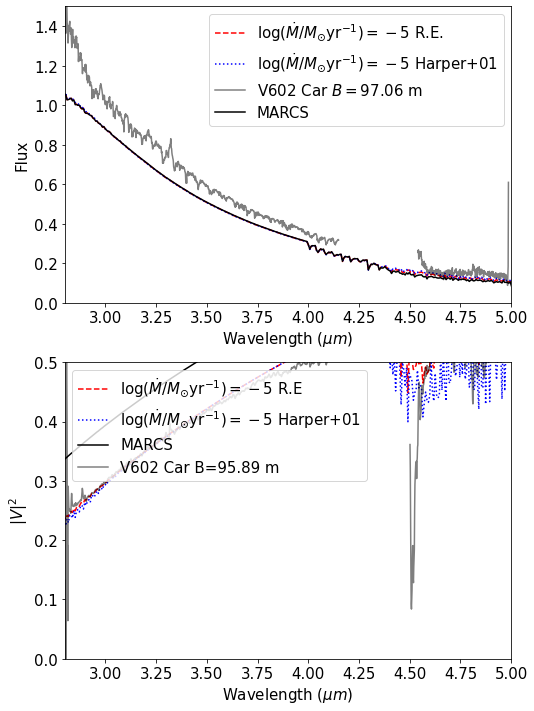

In [60]:
#calculate good visibilities with best fit A and theta ross 
w4visibility1m=[]
w4jvisibility1m=[]
w4mvisibility1m=[]
for i in range(len(baselinesm)):
# Plot to see if everything is alright?
    w4visibility1mi=visibility(bin_wm, t_bin_intensity_muu4m, mus_allu, ratio_rad4, theta_ross, baselinesm[i])
    w4visibility1m.append(w4visibility1mi)
    w4jvisibility1mi=visibility(bin_wm2, t_bin_intensity_muu4mj, mus_allu, ratio_rad4j, theta_ross, baselinesm[i])
    w4jvisibility1m.append(w4jvisibility1mi)
    w4mvisibility1mi=visibility(bin_wm3, t_bin_intensity_muu4mm, mus_allu, ratio_rad4m, theta_ross, baselinesm[i])
    w4mvisibility1m.append(w4mvisibility1mi)
    

Text(0.5, 0, 'Wavelength $(\\mu m)$')

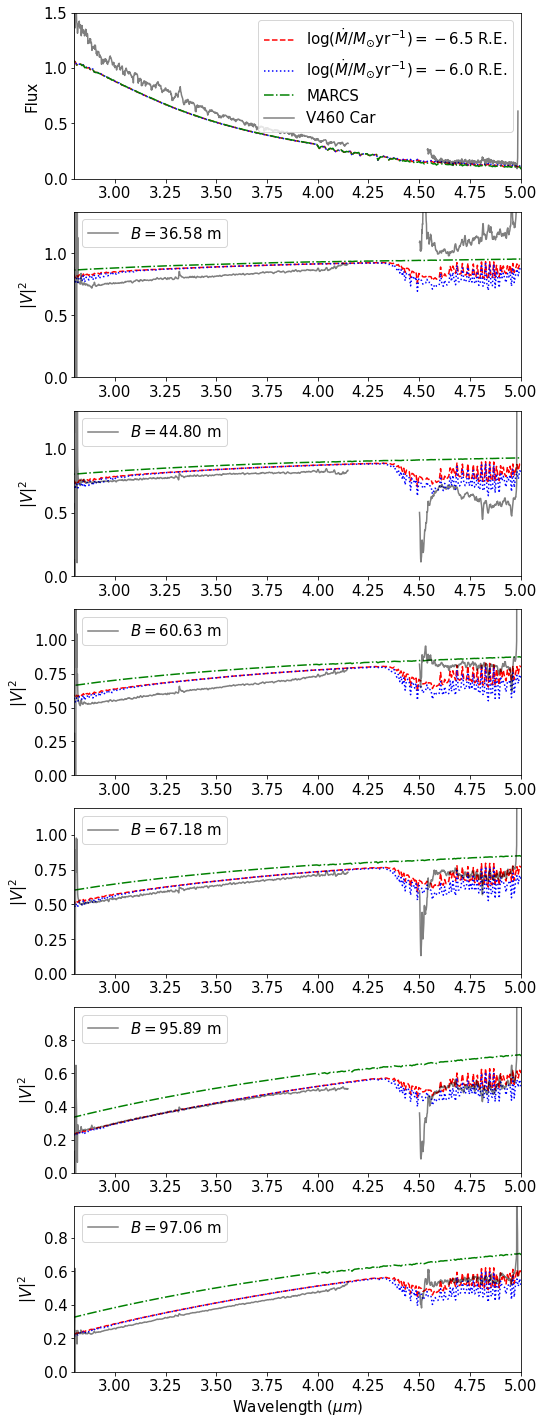

In [61]:
#This is the good plot with all baselines
baselinesm_order=np.sort(baselinesm)
baselinesm_order_idx=np.argsort(baselinesm)
a_mmarcs=a_m
#a_m=0.85
#a_mh=0.85
#so far we have seen baselines[0], let's plot all
#fig = plt.figure(figsize=(8,12))
fig, ax =plt.subplots(len(baselinesm)+1, figsize=(8,25))
#ax[0]=fig.add_subplot(211)

ax[0].plot(bin_wm, bin_flux4m/np.mean(np.array(bin_flux4m)), c="r", ls="--", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6.5$ R.E.")
ax[0].plot(bin_wm2, bin_flux4mj/np.mean(np.array(bin_flux4mj)), c="b", ls=":",label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6.0$ R.E.")
ax[0].plot(bin_wm3, bin_flux4mm/np.mean(np.array(bin_flux4mm)), c="g", ls="-.", label=r"MARCS")
ax[0].plot(w_scom, np.array((f_scom_new))*0.5, c="k", alpha=0.5, label=r"V460 Car")

ax[0].set_ylim(0,1.5)
#ax.set_xlim(min(w1000rad),max(w1000rad))
#ax[0].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
ax[0].set_ylabel(r"Flux", fontsize=15)
ax[0].legend(loc=1,prop={'size':15})
ax[0].tick_params(labelsize=15)
ax[0].set_xlim(2.8, 5.0)

for i in range(1,len(baselinesm_order)+1):
    ax[i].plot(bin_wm, (a_m*w4visibility1m[baselinesm_order_idx[i-1]])**2, c="r", ls="--")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ R.E")
    ax[i].plot(bin_wm2, (a_m*w4jvisibility1m[baselinesm_order_idx[i-1]])**2, c="b", ls=":")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ Harper+01")
    ax[i].plot(bin_wm3, (a_mmarcs*w4mvisibility1m[baselinesm_order_idx[i-1]])**2, c="g", ls="-.")
               #,label=r"MARCS")
#cond_data=(np.array(w_data)>(4.15*1e-6))&(np.array(w_data)<(4.5*1e-6))
    #for i in range():#len(vis2)
    ax[i].plot(np.array(w_data)*1e+6, vis2_new[baselinesm_order_idx[i-1]], c="k", alpha=0.5, label=r"$B=%.2f$ m"%baselinesm[baselinesm_order_idx[i-1]])
    #ax.plot(np.array(w_data)[cond]*1e+6, np.array(vis2)[i][cond], color="white")
    ax[i].set_ylim(0,max((a_mmarcs*w4mvisibility1m[baselinesm_order_idx[i-1]])**2)*1.4)
#ax.set_xlim(min(w1000rad),max(w1000rad))

    ax[i].set_ylabel(r"$|V|^{2}$", fontsize=15)
    ax[i].legend(loc=2,prop={'size':15})
    ax[i].tick_params(labelsize=15)
    ax[i].set_xlim(2.8, 5.0)
ax[-1].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
#fig.savefig("KW-Sgr-MATISSE-model-fit4.png")


#fig.savefig("V460-car-MATISSE-mdot6p0-RE-M-all-baselines-A-theta-fit.png", bbox_inches='tight', dpi=300)
#fig.savefig("AH-Sco-MATISSE-mdot4-RE-H-M-all-baselines.png")

Text(0.5, 0, 'Wavelength $(\\mu m)$')

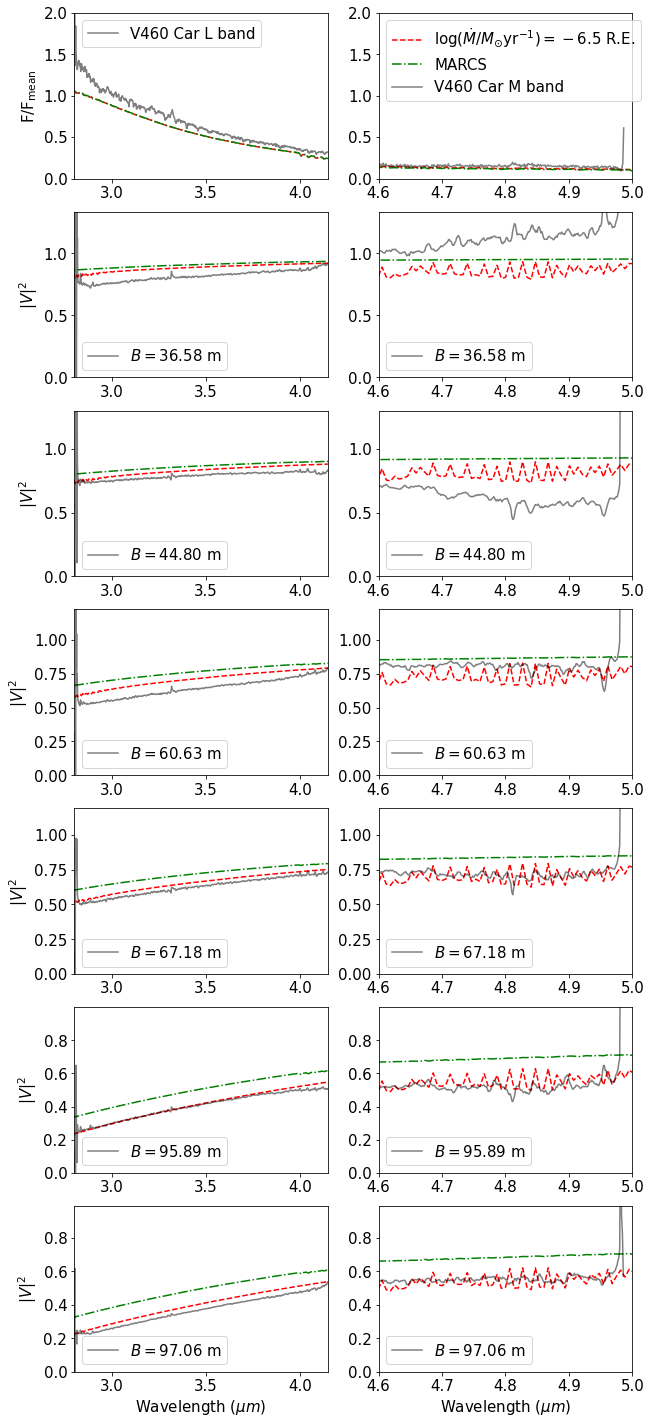

In [62]:
#plot the L and M separately
#a_mmarcs=0.7
#a_m=0.75
baselinesm_order=np.sort(baselinesm)
baselinesm_order_idx=np.argsort(baselinesm)
#so far we have seen baselines[0], let's plot all
#fig = plt.figure(figsize=(8,12))
fig, ax =plt.subplots(len(baselinesm)+1, 2, figsize=(10,25))
#fig, ax =plt.subplots(4,3, figsize=(15,17))
#ax[0]=fig.add_subplot(211)

ax[0,0].plot(bin_wm, bin_flux4m/np.mean(np.array(bin_flux4m)), c="r", ls="--", label=r"")#$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ R.E.
#ax[0,0].plot(bin_wm2, bin_flux4mj/np.mean(np.array(bin_flux4mj)), c="b", ls=":",label=r"")#$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ Harper+01
ax[0,0].plot(bin_wm3, bin_flux4mm/np.mean(np.array(bin_flux4mm)), c="g", ls="-.", label=r"")#MARCS
ax[0,0].plot(w_scom, np.array((f_scom_new))*0.5, c="k", alpha=0.5, label=r"V460 Car L band")

ax[0,0].set_ylim(0,2)
#ax.set_xlim(min(w1000rad),max(w1000rad))
#ax[0].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
ax[0,0].set_ylabel(r"$\mathrm{F/F_{mean}}$", fontsize=15)
ax[0,0].legend(loc=2,prop={'size':15})
ax[0,0].tick_params(labelsize=15)
ax[0,0].set_xlim(2.8, 4.15)

ax[0,1].plot(bin_wm, bin_flux4m/np.mean(np.array(bin_flux4m)), c="r", ls="--", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6.5$ R.E.")
#ax[0,1].plot(bin_wm2, bin_flux4mj/np.mean(np.array(bin_flux4mj)), c="b", ls=":",label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ H")
ax[0,1].plot(bin_wm3, bin_flux4mm/np.mean(np.array(bin_flux4mm)), c="g", ls="-.", label=r"MARCS")
ax[0,1].plot(w_scom, np.array((f_scom_new))*0.5, c="k", alpha=0.5, label=r"V460 Car M band")

ax[0,1].set_ylim(0,2)
#ax.set_xlim(min(w1000rad),max(w1000rad))
#ax[0].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
#ax[0,1].set_ylabel(r"Flux", fontsize=15)
ax[0,1].legend(loc=2,prop={'size':15})
ax[0,1].tick_params(labelsize=15)
ax[0,1].set_xlim(4.6, 5.0)

for j in range(0,2):
   # if j==0:
   #     a_m=0.75
  #      a_mmarcs=0.7
  #  else:
  #      a_m=0.75#1
  #      a_mmarcs=0.7
    for i in range(1,len(baselinesm_order)+1):

        ax[i,j].plot(bin_wm, (a_m*w4visibility1m[baselinesm_order_idx[i-1]])**2, c="r", ls="--")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ R.E")
      #  ax[i,j].plot(bin_wm2, (a_m*w4jvisibility1m[baselinesm_order_idx[i-1]])**2, c="b", ls=":")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ Harper+01")
        ax[i,j].plot(bin_wm3, (a_mmarcs*w4mvisibility1m[baselinesm_order_idx[i-1]])**2, c="g", ls="-.")
               #,label=r"MARCS")
#cond_data=(np.array(w_data)>(4.15*1e-6))&(np.array(w_data)<(4.5*1e-6))
    #for i in range():#len(vis2)
        ax[i,j].plot(np.array(w_data)*1e+6, vis2_new[baselinesm_order_idx[i-1]], c="k", alpha=0.5, label=r"$B=%.2f$ m"%baselinesm[baselinesm_order_idx[i-1]])
    #ax.plot(np.array(w_data)[cond]*1e+6, np.array(vis2)[i][cond], color="white")
        ax[i,j].set_ylim(0,max((a_mmarcs*w4mvisibility1m[baselinesm_order_idx[i-1]])**2)*1.4)
#ax.set_xlim(min(w1000rad),max(w1000rad))

        ax[i,0].set_ylabel(r"$|V|^{2}$", fontsize=15)
        ax[i,j].legend(loc=3,prop={'size':15})
        ax[i,j].tick_params(labelsize=15)
        ax[i,0].set_xlim(2.8, 4.15)
        ax[i,1].set_xlim(4.6, 5.0)
ax[-1,-1].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
ax[-1,0].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
#fig.savefig("KW-Sgr-MATISSE-model-fit4.png")


#fig.savefig("V460-car-MATISSE-mdot6p5-RE-M-all-baselines-A-theta-fit-separate.png", bbox_inches='tight', dpi=300)

No handles with labels found to put in legend.


Text(0.5, 0, 'Wavelength $(\\mu m)$')

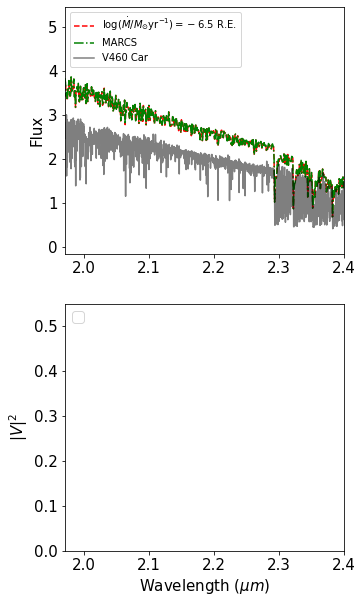

In [63]:
#GRAVITY data with new parameters
a_gmarcs=a_g
#a_gh=1
#Define an array for the baselinesg and the model
w4visibilitymg=[]
w4jvisibilitymg=[]
w4mvisibilitymg=[]

for i in range(len(baselinesg)):
    w4visibility1mg=visibility(bin_wmg, t_bin_intensity_muu4mg, mus_allu, ratio_rad4, theta_ross, baselinesg[i])
    w4visibilitymg.append(w4visibility1mg)
    
    w4jvisibility1mg=visibility(bin_wm2g, t_bin_intensity_muu4mjg, mus_allu, ratio_rad4j, theta_ross, baselinesg[i])
    w4jvisibilitymg.append(w4jvisibility1mg)
    
    w4mvisibility1mg=visibility(bin_wm3g, t_bin_intensity_muu4mmg, mus_allu, ratio_rad4m, theta_ross, baselinesg[i])
    w4mvisibilitymg.append(w4mvisibility1mg)





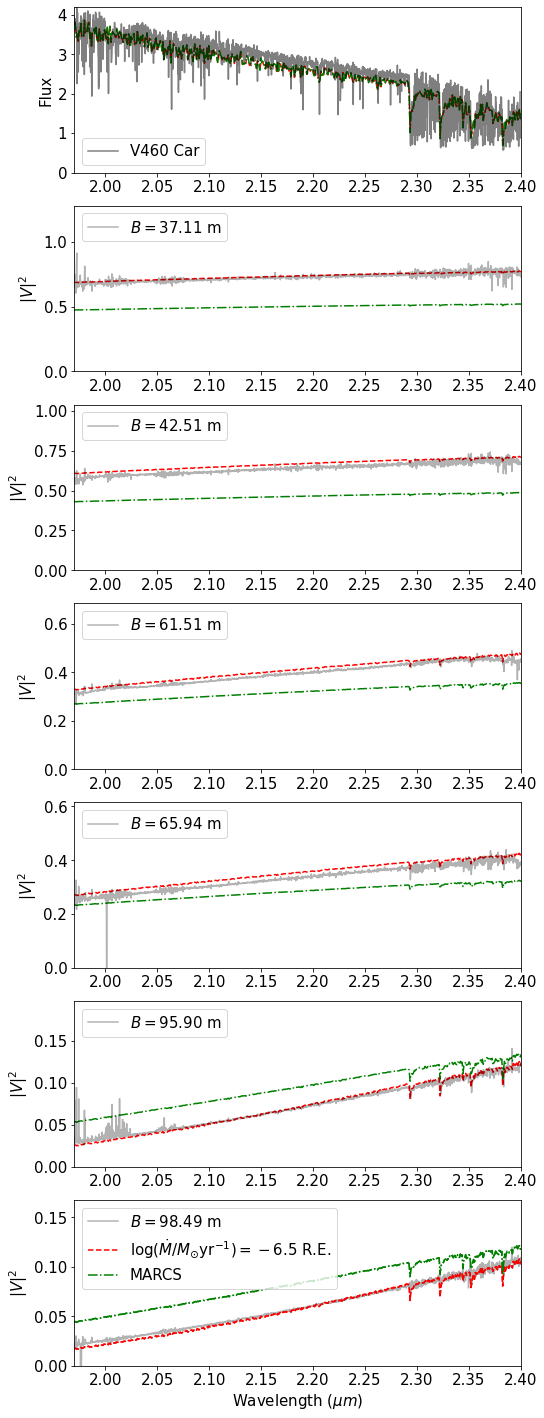

In [72]:
#Plot GRAVITY data with baseline from low to high 
baselinesg_order=np.sort(baselinesg)
baselinesg_order_idx=np.argsort(baselinesg)

#a_g=0.7
a_gmarcs=0.8#a_g
a_gh=a_g

#fig = plt.figure(figsize=(8,12))
fig, ax =plt.subplots(len(baselinesg)+1, figsize=(8,25))
#ax[0]=fig.add_subplot(211)

ax[0].plot(bin_wmg, bin_flux4mg/np.mean(np.array(bin_flux4mg)), c="r", ls="--", label=r"")#$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6.5$ R.E.
#ax[0].plot(bin_wm2g, bin_flux4mjg/np.mean(np.array(bin_flux4mjg)), c="b", ls=":",label=r"")
ax[0].plot(bin_wm3g, bin_flux4mmg/np.mean(np.array(bin_flux4mmg)), c="g", ls="-.", label=r"")
ax[0].plot(np.array(w_scog)*1e-4, np.array((f_scog))*3.5e-6, c="k", alpha=0.5, label=r"V460 Car")

ax[0].set_ylim(0,4.2)
#x.set_xlim(min(w1000rad),max(w1000rad))
#ax[0].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
ax[0].set_ylabel(r"Flux", fontsize=15)
ax[0].legend(loc=3,prop={'size':15})
ax[0].tick_params(labelsize=15)
ax[0].set_xlim(min(wave_SC_Pmean)*1e-4, max(wave_SC_Pmean)*1e-4)

for i in range(1,len(baselinesg)+1):
    ax[i].plot(bin_wmg, (a_g*w4visibilitymg[baselinesg_order_idx[i-1]])**2, c="r", ls="--")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ R.E")
    #ax[i].plot(bin_wm2g, (a_gh*w4jvisibilitymg[baselinesg_order_idx[i-1]])**2, c="b", ls=":")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ Harper+01")
    ax[i].plot(bin_wm3g, (a_gmarcs*w4mvisibilitymg[baselinesg_order_idx[i-1]])**2, c="g", ls="-.")
               #,label=r"MARCS")
#cond_data=(np.array(w_data)>(4.15*1e-6))&(np.array(w_data)<(4.5*1e-6))
    #for i in range():#len(vis2)
    ax[i].plot(np.array(wave_SC_Pmean)*1e-4, vis2_SC_Pmean[baselinesg_order_idx[i-1]], c="k", label=r"$B=%.2f$ m"%baselinesg[baselinesg_order_idx[i-1]], alpha=0.3)
    #ax[i].plot(np.array(w_data)*1e+6, vis2_new[i-1], c="k", alpha=0.5, label=r"$B=%.2f$ m"%baselines[i-1])
    #ax.plot(np.array(w_data)[cond]*1e+6, np.array(vis2)[i][cond], color="white")
    ax[i].set_ylim(0,max(vis2_SC_Pmean[baselinesg_order_idx[i-1]])*1.4)
#ax.set_xlim(min(w1000rad),max(w1000rad))

    ax[i].set_ylabel(r"$|V|^{2}$", fontsize=15)
    ax[i].legend(loc=2,prop={'size':15})
    ax[i].tick_params(labelsize=15)
    ax[i].set_xlim(min(wave_SC_Pmean)*1e-4, max(wave_SC_Pmean)*1e-4)
ax[-1].plot(bin_wmg, (a_g*w4visibilitymg[baselinesg_order_idx[i-1]])**2, c="r", ls="--", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6.5$ R.E.")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ R.E")
#ax[-1].plot(bin_wm2g, (a_gh*w4jvisibilitymg[baselinesg_order_idx[i-1]])**2, c="b", ls=":", label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-6.0$ R.E.")
               #, label=r"$\log (\dot{M}/M_{\odot}\mathrm{yr}^{-1})=-4$ Harper+01")
ax[-1].plot(bin_wm3g, (a_gmarcs*w4mvisibilitymg[baselinesg_order_idx[i-1]])**2, c="g", ls="-.", label="MARCS")
ax[-1].legend(loc=2,prop={'size':15})
ax[-1].set_xlabel(r"Wavelength $(\mu m)$", fontsize=15)
#
#fig.savefig("V460-Car-GRAVITY-mdot6p5-RE-M-all-baselines-A-theta-fit-all-lamb.png", bbox_inches='tight', dpi=300)

In [65]:
print("Fitting results: ")
print("Theta Ross: ",theta_ross)
print("A gravity: ",a_g)
print("A matisse: ",a_m)

Fitting results: 
Theta Ross:  3.949999999999993
A gravity:  1.0000000000000002
A matisse:  1.0000000000000002


In [66]:
#calculate the errors
condition=chisq<(np.min(chisq)+2.30) #68% confidence level for 2 parameters
cond_chisq=chisq[condition]
    #fig =plt.figure(figsize=(15,10))
    #ax= fig.add_subplot((111))
    #ax.plor()
print(cond_chisq)
indexes=np.where(condition)
print(np.where(condition), indexes[0], theta_ross_arr[indexes[0]], indexes[1],a_arr_g[indexes[1]] )

[177.14698775]
(array([39]), array([6])) [39] [3.95] [6] [1.]


In [67]:
print(a_g,max(a_arr_g[indexes[1]]), min(a_arr_g[indexes[1]]))
print(theta_ross,max(theta_ross_arr[indexes[0]]), min(theta_ross_arr[indexes[0]]))

1.0000000000000002 1.0000000000000002 1.0000000000000002
3.949999999999993 3.949999999999993 3.949999999999993
